# <span style='color:blue'> LAB 7: </span>
# <span style='color:blue'> ATTENTION-MECHANISM TRANSFORMER ARCHITECTURE </span>

In [22]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

np.random.seed(0)
torch.manual_seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### For more on PyTorch Transformer support for language translation: https://pytorch.org/tutorials/beginner/translation_transformer.html

## Download the tokenization library

We will learn what these are later. For now, your goal is to run the following code.

In [31]:
en_token_transform = get_tokenizer('spacy', language='en_core_web_sm')
fr_token_transform = get_tokenizer('spacy', language='fr_core_news_sm')

If you get an error saying something along the lines of "the computer can't find this", it's because you haven't downloaded the tokenization libraries yet. To do that, you should open up command terminal and run the following code:

python -m spacy download en_core_web_sm

python -m spacy download fr_core_news_sm


Bada bing bada boom

## Download data

In [4]:
# Load data as a list of tuples
with open("en_to_fr_full.txt", "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

text_pairs = []
for l in lines:
    appendage = l.split("\t")
    text_pairs.append(appendage)

# Print the first ten samples
for i in range(10): 
    print(text_pairs[i][0], text_pairs[i][1]) 


Hi. Salut!
Stop! Arrête-toi !
I won! J'ai gagné !
Get up. Lève-toi.
Hop in. Montez.
I paid. J’ai payé.
No way! Il n'en est pas question !
We won. Nous gagnâmes.
Be fair. Soyez juste !
Be nice. Soyez gentils !


## Create source and target language tokenizers

In [8]:
# Download source and target language tokenizers
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'

token_transform = {}
token_transform[SRC_LANGUAGE] = en_token_transform
token_transform[TGT_LANGUAGE] = fr_token_transform
# hint: if you get an OSError, try running the following lines from the command line:
# python -m spacy download en_core_web_sm
# python -m spacy download fr_core_news_sm

en_0_tokenized = token_transform[SRC_LANGUAGE](text_pairs[0][1]) 
fr_0_tokenized = token_transform[TGT_LANGUAGE](text_pairs[0][0]) 

# Print the tokenized first line of each dataset
print(en_0_tokenized) 
print(fr_0_tokenized)

['Les', 'médicaments', 'et', "l'alcool", 'font', 'rarement', 'bon', 'ménage', '.']
['Medication', 'and', 'alcohol', 'often', "don'", 't', 'mix', '.']


## Create a vocabulary for each language's dataset

In [9]:
# Special tokens: a "unique" filler-token to use when we can't tokenize a particular word, a "padding" token, a "beginning-of-sentence" token and an "end-of-sentence" token. 
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

# And their special indeces in our vocabulary
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# A helper function that converts a list of strings into a list of lists-of-tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        try:
          yield token_transform[language](data_sample[language_index[language]])
        except IndexError:
          print(f"token_transform.keys(): {token_transform.keys()}")
          print(f"language: {language}")
          print(f"data_sample: {data_sample}")
          print(f"language_index: {language_index}")
          raise IndexError

# Create a vocabulary object for each language using the build_vocab_from_iterator function
vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Invoke torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(text_pairs, ln),
                                                    min_freq=1,
                                                    specials=special_tokens,
                                                    special_first=True)


# ``UNK_IDX`` is the index returned when the token is not found.
# If we don't use this, we'll get a ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

# Let's see the first 20 words in each vocabulary
print(vocab_transform[SRC_LANGUAGE].get_itos()[:20])
print(vocab_transform[TGT_LANGUAGE].get_itos()[:20]) 

['<unk>', '<pad>', '<bos>', '<eos>', '.', 'I', 'you', 'to', '?', 'the', "n't", 'a', 'is', 'do', 'Tom', "'s", 'that', 'of', 'You', 'in']
['<unk>', '<pad>', '<bos>', '<eos>', '.', 'de', 'Je', '?', 'pas', 'est', 'que', 'à', 'ne', 'la', 'le', 'a', 'Tom', "n'", 'un', 'Il']


## Train-Validate-Test split

In [10]:
# Shuffle the text pairs
shuffler = np.random.permutation(len(text_pairs))
text_pairs = [text_pairs[i] for i in shuffler] 

# Train-validate-test split: 80-10-10
n_train = int(0.8*len(text_pairs))
train_pairs = text_pairs[:n_train] 

n_val = int(0.1*len(text_pairs))
val_pairs = text_pairs[n_train:n_train+n_val]

n_test = int(0.1*len(text_pairs))
test_pairs = text_pairs[n_train+n_val:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

17563 total pairs
14050 training pairs
1756 validation pairs
1757 test pairs


### Mask functions

In [11]:
# Helper
def generate_square_subsequent_mask(sz): 
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Mask function
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Collation

In [12]:
# A helper function to club together sequential operations
def sequential_transforms(*transforms): 
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Adds BOS/EOS and creates a tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms convert the raw strings into tensors indices
text_transform = {} 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# The "collation" function collates data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

# Training, evaluation functions

In [13]:
# This function trains the model for a single epoch
def train_epoch(model, optimizer):
    model.train()
    loss_list = []
    train_iter = train_pairs
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        # Since we're training, recall we need to mask our input
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # What do you think the model does with the masks when it's in evaluation mode?
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        loss_list.append(loss.item())

    return loss_list

# Evaluates the model
def evaluate(model):
    model.eval()
    loss_list = []

    val_iter = val_pairs
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss_list.append(loss.item())

    return loss_list

## Define model

In [14]:
# The PositionalEncoding module quantifies the relative position of words in a sentence
# Notice that this is not actually an MLP or neural network, i.e. it has no learned parameters
# it is just a function that you could represent analytically, if you wanted to
class PositionalEncoding(nn.Module): # <-- "Embedding"
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# The TokenEmbedding module converts a tensor of vocabulary-indices into a tensor of token-embeddings
# Also not a neural network, but a lookup table
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Sequence-to-sequence transformer 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 embedding_size,
                 num_heads,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_feedforward = 512,
                 dropout = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=embedding_size,
                                       nhead=num_heads,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(embedding_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, embedding_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(
            embedding_size, dropout=dropout)

    def forward(self,
                src,
                trg,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src)) # source sequence --> token embedding --> positional encoding
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg)) # target sequence --> token embedding --> positional encoding
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## Define hyperparameters

In [15]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE]) 
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NUM_HEADS = 8 # Why 8? What do you expect to happen if we increase this parameter?
FFN_HID_DIM = 512 
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 6

## Instantiate model, loss function, optimizer

In [19]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NUM_HEADS, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## Train the model

In [20]:
# Fair warning: you might get an "out of memory" error
# If that happens, try reducing the batch size

train_loss_list = []
val_loss_list = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))


Epoch: 1, Epoch time = 29.425s
Epoch: 2, Epoch time = 29.074s
Epoch: 3, Epoch time = 53.165s
Epoch: 4, Epoch time = 40.807s
Epoch: 5, Epoch time = 29.449s
Epoch: 6, Epoch time = 41.696s


# Visualize and Evaluate the Model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


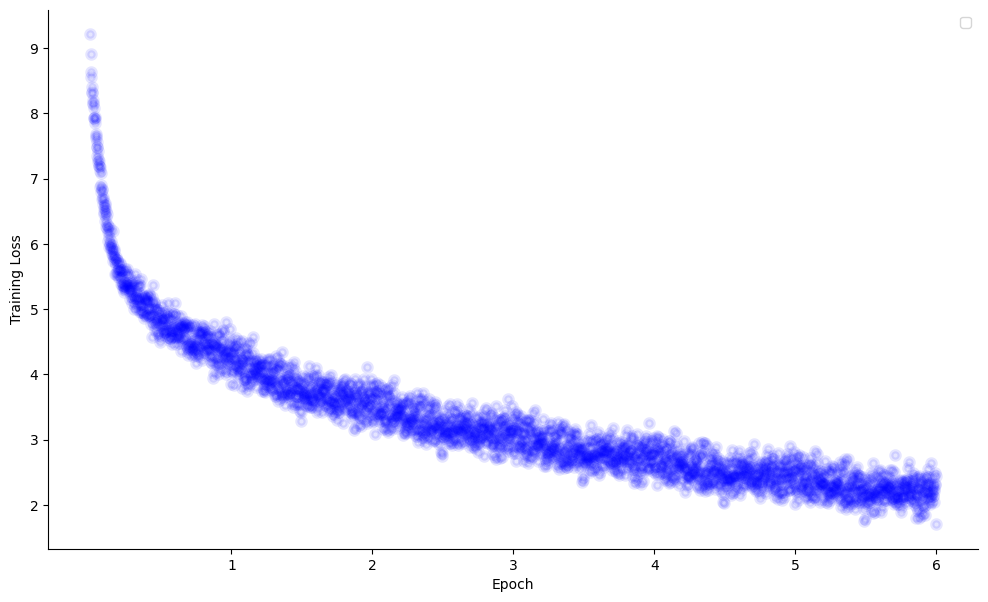

In [29]:
# Plot the loss
plt.figure(figsize = (12, 7))

plt.scatter(range(len(train_loss_list)), train_loss_list, color = 'blue', linewidth = 3, alpha=0.1)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.xticks(ticks = [(i+1)*len(train_loss_list)//NUM_EPOCHS for i in range(NUM_EPOCHS)], labels=[f"{i+1}" for i in range(NUM_EPOCHS)])
plt.legend()
sns.despine()

Print the last 10 target/translated sequences from test set

In [30]:
# Function to generate output sequence using greedy algorithm
# This basically saves us some compute time by taking a bunch of shortcuts (e.g. not computing the full softmax)
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

# Actual function to translate input sentence into target language
# Translation function that actually uses the model to translate a sentence from source to target
def translate(model, src_sentence):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

for i in range(10):
    test_pair = test_pairs[-i]
    test_str_de = test_pair[0]
    test_str_en = test_pair[1]
    print(f"Target: {test_str_en}")
    print("Model output:", translate(transformer, test_str_de))
    print("")

Target: Je n'ai jamais porté de smoking.
Model output:  Je n' ai jamais jamais eu une seconde . 

Target: Tout le monde adorait Tom.
Model output:  Tout le monde a été à Tom . 

Target: Tu ne peux pas avoir ces deux livres.
Model output:  Tu ne peux pas les deux deux . 

Target: J'ai été réveillé à cinq heures.
Model output:  J' étais en train de cinq heures . 

Target: Nous nous sommes rencontrés à l'aéroport.
Model output:  Nous sommes en train d' accord en train de l' hôpital . 

Target: J'ai trouvé un livre rare que j'avais recherché.
Model output:  J' ai trouvé un livre que j' ai été en train de l' air . 

Target: Dans quel but l'as-tu acheté ?
Model output:  Qu' as - tu fait en train de l' heure ? 

Target: Êtes-vous toujours mariées ?
Model output:  Êtes -vous toujours toujours ? 

Target: Mon cousin se marie demain.
Model output:  Mon fils me se passe à demain . 

Target: Tom n'a pas eu le temps de réagir.
Model output:  Tom n' a pas l' heure de temps à l' air . 

